In [1]:
import rasterio as rio

import earthpy.spatial as es
from matplotlib import pyplot
import pandas as pd
import geopandas as gpd

import numpy as np
from scipy import stats
import os
import glob

import xarray as xr
import rioxarray

For starting I need to identify the growing season to specify dates for the Landsat 7 data

In [2]:
crop_data = pd.read_excel('thermal_data_2021/twitchell_ET_2011.xls')
crop_data.head()

,Year,Month,Day,Julian,Unnamed: 4,crop.type,Tmx,Tmn,VPD,NDVI,EVI,ET
0,2011,1,1,1,731,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
1,2011,1,2,2,732,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
2,2011,1,3,3,733,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
3,2011,1,4,4,734,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
4,2011,1,5,5,735,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567


<AxesSubplot:xlabel='Julian'>

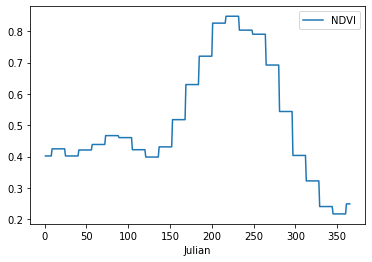

In [3]:
crop_data.plot('Julian', 'NDVI')

After plotting the graph I will define the growing season to where NDVI is above 0.5

Then I will quickly check the minimum and maximum 'Month' values (first and last) and this will give me a guide for the dates to specify. In this case it will be between June and October

In [4]:
growing_season = crop_data[crop_data['NDVI'] > 0.5]
growing_season['Month'].describe()

count    144.000000
mean       7.909722
std        1.368544
min        6.000000
25%        7.000000
50%        8.000000
75%        9.000000
max       10.000000
Name: Month, dtype: float64

After downloading the data from https://earthexplorer.usgs.gov/ using the specified dates, its time to load and sort the data. I only need the thermal 2 band from each scene (In this case band 6-2). I will label them using the date.

In [5]:
DN_tifs = glob.glob('thermal_data_2021/DNs/**/*B6_VCID_2.TIF', recursive=True)
DN_tifs.sort()

dates = list(os.walk('thermal_data_2021/DNs/'))[0]
dates = dates[1]
dates.sort()

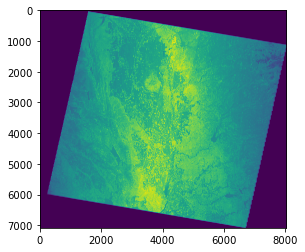

In [6]:
#visualise one raster to make sure everything looks correct. Throughout this exercise I will visualise the image from 8th July 2011

with rioxarray.open_rasterio('thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B6_VCID_2.TIF') as src:
    DN_layer = src

pyplot.imshow(DN_layer.squeeze())

In [7]:
# #visualise one raster to make sure everything looks correct. Throughout this exercise I will visualise the image from 8th July 2011

# with rio.open('thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B6_VCID_2.TIF') as src:
#     DN_layer = src.read().transpose(1,2,0)
#     print(src.profile)
# pyplot.imshow(DN_layer)

In [8]:
DN_layer

<xarray.DataArray (band: 1, y: 7081, x: 8031)>
[56867511 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.926e+05 4.926e+05 ... 7.335e+05 7.335e+05
  * y            (y) float64 4.414e+06 4.414e+06 ... 4.201e+06 4.201e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [9]:
# define the function to calculate Top of Atmosphere (TOA) radiance

Lmax = 12.650
Lmin = 3.200
Qcalmax = 255
Qcalmin = 1

def TOA_radiance(DN):
    return (Lmax-Lmin) / (Qcalmax-Qcalmin) * (DN-Qcalmin) + Lmin


In [10]:
# loop through images, calculate TOA Radiance and save to disc

for tif, date in zip(DN_tifs, dates):
    with rioxarray.open_rasterio(tif) as src:
        data = src
        
#         #set and mask out no data values
#         data.rio.write_nodata(0, inplace=True)
#         nodata = data.rio.nodata
#         data = data.where(data != nodata)
#         data.rio.write_nodata(nodata, encoded=True, inplace=True)
        
        #apply radiance equation
        data = TOA_radiance(data)
        
#         #set the nodata value from max to min (mainly for visualisation)
#         data = data.where(data < int(data.max()), other=int(data.min()))
        
        #save to tif
        data.rio.to_raster(f'thermal_data_2021/TOA_Radiance/{date}_radiance.tif')
       


In [11]:
# DN_arrays = glob.glob('thermal_data_2021/DNs/*.npy')
# DN_arrays.sort()

# for DN, date in zip(DN_arrays, dates):
#     array = np.load(f'thermal_data_2021/DNs/{date}_DN_array.npy')
#     array = TOA_radiance(array)
#     np.save(f'thermal_data_2021/TOA_Radiance/{date}_TOA_radiance', array)

(array([2.2160000e+03, 1.9700000e+02, 1.9400000e+02, 2.8843000e+04,
        1.2090800e+05, 6.1978300e+05, 1.0243310e+07, 9.9771720e+06,
        8.3863190e+06, 2.7488569e+07]),
 array([ 3.2       ,  4.14872047,  5.09744094,  6.04616142,  6.99488189,
         7.94360236,  8.89232283,  9.84104331, 10.78976378, 11.73848425,
        12.68720472]),
 <BarContainer object of 10 artists>)

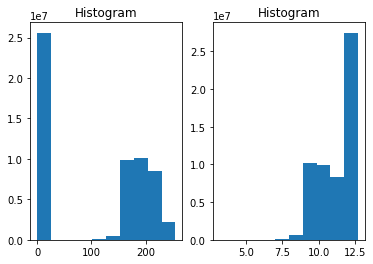

In [12]:
# compare DN to radiance values

#load the new radiance raster layer
with rioxarray.open_rasterio('thermal_data_2021/TOA_Radiance/20110708_radiance.tif') as src:
    RAD_layer = src


# plot histograms
fig, (ax1, ax2) = pyplot.subplots(1, 2)
ax1.set_title('Histogram of raw DNs')
DN_layer.plot.hist(ax=ax1)
ax2.set_title('Histogram of TOA radiance values')
RAD_layer.plot.hist(ax=ax2)



In [13]:
RAD_layer.max()

<xarray.DataArray ()>
array(12.68720472)
Coordinates:
    spatial_ref  int64 0

In [14]:
# define function to calculate Top of Atmosphere (TOA) brightness values

K1 = 666.09
K2 = 1282.71

def TOA_brightness(radiance):
    return (K2/(np.log(K1/radiance+1)))-272.15



In [ ]:
# loop through images, calculate TOA Brightness and save to disc
RAD_tifs = glob.glob('thermal_data_2021/TOA_Radiance/*.tif')
RAD_tifs.sort()

for tif, date in zip(RAD_tifs, dates):
    with rioxarray.open_rasterio(tif) as src:
        data = src
        
#         #set and mask out no data values
#         data.rio.write_nodata(0, inplace=True)
#         nodata = data.rio.nodata
#         data = data.where(data != nodata)
#         data.rio.write_nodata(nodata, encoded=True, inplace=True)

        
        
        #apply brightness equation
        data = TOA_brightness(data)
        
        #set the nodata value from max to min (mainly for visualisation)
        data = data.where(data < int(data.max()), other=int(data.min()))
        
        #save to tif
        data.rio.to_raster(f'thermal_data_2021/TOA_Brightness/{date}_brightness.tif')
       

In [ ]:
with rioxarray.open_rasterio('thermal_data_2021/TOA_Brightness/20110708_brightness.tif') as src:
    BRI_layer = src

In [ ]:
int(BRI_layer.min())

In [ ]:
#BRI_layer = BRI_layer.where(BRI_layer < 50, other=int(BRI_layer.min()))

In [ ]:
#using a single date for comparison (8 July 2011)

fig, axs = pyplot.subplots(2, 3, figsize=(15,10))
axs[0,0].set_title('raw DNs')
axs[0,0].imshow(DN_layer.squeeze())
axs[0,1].set_title('TOA radiance')
axs[0,1].imshow(RAD_layer.squeeze())
axs[0,2].set_title('TOA Brighness converted to Degrees C')
axs[0,2].imshow(BRI_layer.squeeze(), cmap='jet')
axs[1,0].set_title('Histogram of DN values')
DN_layer.plot.hist(ax=axs[1,0])
axs[1,1].set_title('Histogram of TOA radiance values')
RAD_layer.plot.hist(ax=axs[1,1])
axs[1,2].set_title('Histogram of TOA Brighness values (converted to Deg C)')
BRI_layer.plot.hist(ax=axs[1,2])


In [ ]:
#compare TOA Radiance and TOA Brightness with sample tifs to ensure correct calculations

#open sample tiffs
with rioxarray.open_rasterio('thermal_data_2021/LS TOA/tifs/LS20110708TOA.tif') as src:
    sample_radiance = src

with rioxarray.open_rasterio('thermal_data_2021/LS Brighntess T/tifs/LS20110708degC.tif') as src:
    sample_brightness = src



In [ ]:
# render raster and plot histograms of my and sample Radiance values


fig, axs = pyplot.subplots(2, 2, figsize=(15,10))
axs[0,0].set_title('TOA radiance')
axs[0,0].imshow(RAD_layer.squeeze())
axs[1,0].set_title('Histogram of TOA radiance values')
RAD_layer.plot.hist(ax=axs[1,0])
axs[0,1].set_title('TOA radiance of comparison data')
axs[0,1].imshow(sample_radiance.squeeze())
axs[1,1].set_title('Histogram of TOA radiance values of comparison data')
sample_radiance.plot.hist(ax=axs[1,1])

In [ ]:
# render raster and plot histograms of my and sample Brightness values

fig, axs = pyplot.subplots(2, 2, figsize=(15,10))
axs[0,0].set_title('TOA brightness')
axs[0,0].imshow(BRI_layer.squeeze(), cmap='jet')
axs[1,0].set_title('Histogram of TOA brightness values')
BRI_layer.plot.hist(ax=axs[1,0])
axs[0,1].set_title('TOA Brightness of comparison data')
axs[0,1].imshow(sample_brightness.squeeze(), cmap='jet')
axs[1,1].set_title('Histogram of TOA brightness values of comparison data')
sample_brightness.plot.hist(ax=axs[1,1])

In [ ]:
# next, need to create ploygon of field and use rasterstats to extract brightness values
# and add them to the excel file and plot brightness with NDVI or ET.

# the problem will be to extract/join the correct dates. perhaps creeate new df with average values and date, convert to julian and use join, inner, column=julian...